<h1 align="center">Basic Models: A Sentiment Analysis Case Study on movie reviews</h1>

The goal for this analysis is to predict if a review rates the movie positively or negatively. Inside this dataset there are 25,000 labeled movies reviews for training, 50,000 unlabeled reviews for training, and 25,000 reviews for testing.

- IMDB movie reviews dataset
- http://ai.stanford.edu/~amaas/data/sentiment
- Contains 25000 positive and 25000 negative reviews
<img src="https://i.imgur.com/lQNnqgi.png" align="right">
- Contains at most reviews per movie
- At least 7 stars out of 10 $\rightarrow$ positive (label = 1)
- At most 4 stars out of 10 $\rightarrow$ negative (label = 0)
- 50/50 train/test split
- Evaluation accuracy

## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import pandas as pd

# for importing data to colab
from google.colab import drive 
drive.mount('/content/drive')

# read from local
# movies = pd.read_csv('data/imdb_data.csv')
# movies.sample(7)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preliminary Data Exploration

In [3]:
movies = pd.read_csv('/content/drive/My Drive/Colab Notebooks/imdb_data.csv')
movies.sample(7)

,review,sentiment
43510,"I watched this with great trepidation, and my ...",negative
23613,I have seen a number of horror movies to know ...,positive
47282,"The 1980s TV show, updated with fresh female f...",negative
46861,I like 50s sci-fi movies a lot. I like the rea...,negative
45731,Let's get one thing straight: I like much of S...,negative
45668,Just got this in the mail and I was positively...,positive
22613,Marjorie (a splendid and riveting performance ...,positive


In [4]:
movies.dtypes

review       object
sentiment    object
dtype: object

In [5]:
movies.isna().sum()

review       0
sentiment    0
dtype: int64

In [6]:
#sentiment count
movies['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

> No missing values in the dataset

In [11]:
# Looking at sample review
sample = 777
sample_review = movies.review.iloc[sample]
print(sample_review)
print("\nAssigned sentiment: ", movies.sentiment.iloc[sample])

It's amazing that such a cliche-ridden yuppie angst film actually got made in the first place. The characters are so weak, and the acting so uninspired, that it's impossible to care about any of them-- especially Brooke Shields. The temptation to fast forward through the slow parts is almost irresistible. If you like this genre, you'd be better off renting "Singles," or "Bodies, Rest & Motion."

Assigned sentiment:  0


> **Contains html tags, accented characters, punctutations and emoticons, numbers... etc., Should deal with them in the preprocessing step**

In [8]:
# Cateogrize positive and negative as 1 and 0 respectively
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
movies['sentiment'] = label_encoder.fit_transform(movies['sentiment'])
movies.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

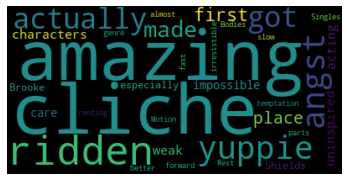

In [12]:
from wordcloud import WordCloud, STOPWORDS

my_stop_wrods = set(STOPWORDS)
my_stop_words = STOPWORDS.update(['movie', 'cinema', 'theatre', 'movies', 'TV', 'film', 'films', 'br', 'one'])

my_cloud = WordCloud(stopwords=my_stop_words).generate(sample_review)
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

## Preprocessing

In [14]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import os
import multiprocessing


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
!pip install langdetect

     |████████████████████████████████| 983kB 2.7MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=d1d8653ba2256c54f352a30306697f0a3732416317f238c1f2ae8162e85b4f87
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [19]:
# Looking for languages
from langdetect import detect_langs

languages =[]
# pick 500 random reviews out of the dataset as langauge detection on every review is not feasible
samples = np.random.choice(len(movies.review), size = 2000, replace = False)
# Loop over the rows of the dataset and append  
for row in samples:
    languages.append(detect_langs(movies.review[row]))

# Clean the list by splitting     
languages = [str(lang).split(':')[0][1:] for lang in languages]

print(np.unique(languages))

['en']


> **We can be fairly certain all the reviews are in english. No need to consider other languages while preprocessing**

In [0]:
# Finding out the most frequent words in our specific dataset to add stopwords customized to the movie reviews domain
from collections import Counter

top_N = 50

stopwords = nltk.corpus.stopwords.words('english')
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (movies.review
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DataFrame out of Counter
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

In [21]:
rslt.transpose()

,Frequency
Word,
',154326
/><br,100980
.,62875
movie,61492
",",61228
/>,56642
film,55086
one,44983
like,37281


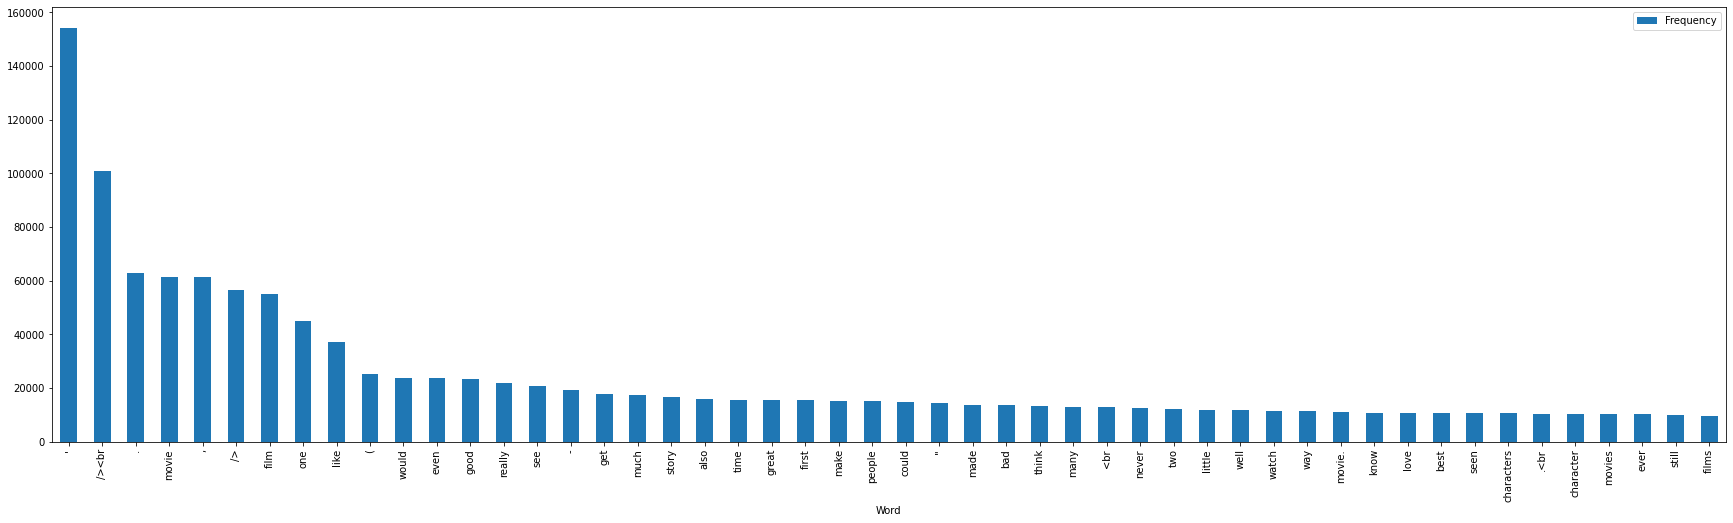

In [22]:
# plot
rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

### Helper functions to aid in preprocessing the text

In [34]:
def sample_reviews():
    for review in movies['review'].sample(7):
        print(review)
        print("")

sample_reviews()

(aka: BLOOD CASTLE or SCREAM OF THE DEMON)*spoiler*This was a drive-in feature, co-billed with THE VELVET VAMPIRE. A Spanish-Italian co-production where a series of women in a village are being murdered around the same time a local count named Yanos Dalmar is seen on horseback, riding off with his 'man-eating' dog behind him.The townsfolk already suspect he is the one behind it all and want his castle burned down. The murders first began around the time Count Yanos' older brother, Count Igor Dalmar was horribly burned and killed in a lab accident.Then a woman Ivanna (Erna Schuer) that Igor hired before his death to assist him in his experiments shows up. Yanos agrees to hire her in place of his brother and together they seek the formulae for the regeneration of dead cells. Yanos wants to bring Igor's charred corpse back to life.But of course Igor is still alive (although horribly burned) and stalking and killing the women in the village. We see his char-broiled face appear at various p

In [33]:
def strip_html_tags(review_text):
    soup = BeautifulSoup(review_text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text
movies['review'] = movies['review'].apply(strip_html_tags)
sample_reviews()

It's about time we see a movie that stays unbiased towards these old Indian traditions. At times it is clear how most of the 'doctors' are charlatans, even lying about how they don't charge their clients. While they are wearing their gold watches, the 'donation' box is mandatory. Notice that there are only a couple of people who get 'cured' while we see quite a few cases.Keep in mind while watching that ingesting mercury is not toxic and that the smallest Indian bank note is 5 rupee, while the average salary in India is 1,700 ru/month.

It was a painful experience, the whole story is actually there so I won't go into that but the acting was horrible there is this part in the very beginning when the scientist brother goes to work he actually wears a white coat at home before leaving to work, I thought working with biohazard material meant that you should wear sterilized clothes in a controlled environment and the lab itself looks like a school lab there is this monitor on top a file cab

In [36]:
import unicodedata

def replace_accented_chars(review_text):
    unaccented_text = unicodedata.normalize('NFKD', review_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return unaccented_text
movies['review'] = movies['review'].apply(replace_accented_chars)
sample_reviews()

First of all, I wasn't sure who this film was aimed at - it seemed like a story for kids but had stuff in it kids wouldn't understand and find boring. There wasn't really much to it, Bruce Willis wasn't stretched as an actor at all. He did a lot of glancing to the side with that half smile of his - unless you are a big fan of his I wouldn't bother. And if it's the story you're interested in (guy who seems to have it all but is lacking emotionally is taught lessons from a child), I would go to see About A Boy. It has everything this film lacked, humor, sadness and reality.

If you are having trouble sleeping or just want to take that nap in the afternoon but just can't seem to drift off, pop in this movie. The only neat thing about this movie are the electric planes. Aside from that prepare for some sweet zzzzz's. It boggles the mind how big name stars such as those in this movie can be part of the one of the dullest movies I've ever seen. Now, if you will excuse me, I will finish my na

In [37]:
def remove_special_characters(review_text):
    """ 
    Remove special characters but preserve digits and excalamation marks
    as they indicate emotionally charged review """
    review_text = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", review_text)
    return review_text

movies['review'] = movies['review'].apply(remove_special_characters)
sample_reviews()

This is a by the numbers horror film starring Richard Crenna and Joanna Pettet as a psychologist duo who purchase and old mansion and invite a small crew of friends and patients to help clean the place up  Unbeknownst to them  the mansion harbors a cellar door   the gateway to hell  If you are in the mood for a cliched horror film  then look no further  but if you want something inventive  then this little film won't appeal to you VIOLENCE       Rather subdued  albeit the scene where a guy cuts his hand with a saw   rather gruesome mind you  Fans of inventive deaths scenes will not like this as every character seems to be electrocuted in some fashion  NUDITY     Nothing to speak of  Mary Louise Weller adds the good looks but her character was underdeveloped  STORY      Cliched  but view worthy nonetheless  This offers nothing new to the genre but the casting of Victor Buono   who is about as menacing as a department store Santa   seems to have attracted a few viewers  ACTING      The b

In [0]:
!pip install contractions
!pip install textsearch

In [38]:
import contractions
def expand_contractions(review_text):
    review_text = contractions.fix(review_text)
    return review_text
movies['review'] = movies['review'].apply(expand_contractions)
sample_reviews()

     |████████████████████████████████| 245kB 3.6MB/s 
     |████████████████████████████████| 317kB 16.3MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81692 sha256=a7aeb08bc9d158d64428b2b2bd4c6bd99ad08903904f6dd8b5c5aad322f1cfb6
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
This may be the most tension filled movie I have ever seen In fact  it is so nerve wracking  I have not been able to watch it again after viewing it two years ago  but I will since I have the DVD  There were a couple of scenes in here that are almost too much to watch    so if you have got problems and need to  escape  for an hour and half this film will get your mind off anything else  The Russian actress Marina Zudina did a super job in facial expressions alone  which she had to do since her character in here is a mute  She plays a cute and wholesome makeup artist f

In [39]:
""" todo: check whether we need this after evaluation 
def preprocess(review_text):
    review_text = strip_html_tags(review_text)
    review_text = replace_accented_chars(review_text)
    review_text = remove_special_characters(review_text)
    review_text = expand_contractions(review_text)
    # review_text = re.sub('\[[^]]*\]', '', review_text)

    review_text = re.sub(r"!", " ! ", review_text)
    review_text = re.sub(r"\?", " ? ", review_text)
    review_text = re.sub(r"\s{2,}", " ", review_text)

    return review_text

movies['sentiment'] = movies['sentiment'].apply(preprocess)
"""

' todo: check whether we need this after evaluation \ndef preprocess(review_text):\n    review_text = strip_html_tags(review_text)\n    review_text = replace_accented_chars(review_text)\n    review_text = remove_special_characters(review_text)\n    review_text = expand_contractions(review_text)\n    # review_text = re.sub(\'\\[[^]]*\\]\', \'\', review_text)\n\n    review_text = re.sub(r"!", " ! ", review_text)\n    review_text = re.sub(r"\\?", " ? ", review_text)\n    review_text = re.sub(r"\\s{2,}", " ", review_text)\n\n    return review_text\n\nmovies[\'sentiment\'] = movies[\'sentiment\'].apply(preprocess)\n'

In [48]:
def strip_stops(review_text, is_lower_case=False, custom = True):
    tokens = word_tokenize(review_text)
    tokens = [token.strip() for token in tokens]
    if custom:
        stop_words = set(nltk.corpus.stopwords.words('english'))
        # custom stopwords added from the most frequent words which are generic and might not relate to the sentiment of the review
        stop_words.update(['movie', 'film', 'one', 'would', 'even', 'really', 'movies', 'films', 'cinema'])
    else:
        stop_words = set(nltk.corpus.stopwords.words('english'))
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

movies['review'] = movies['review'].apply(strip_stops)
sample_reviews()

Viewed GREAT Classic Greta Garbo thought performance excellent However German version English captions greatest performance Greta Garbo mentioned press German favorite make change Silent sound Greta high pitched voice take lessons order lower voice future roles story sad Greta Garbo Anna Christie Ninotchka '39 abused farm young boys father left years ago sailor coal barge captain many scenes Old NYC Brooklyn Bridge Coney Island sky line Manhattan Charles Bickford Matt Burke Days Wine Roses '62 Classic veteran actor gave great supporting role

could help relish entire premise CAT BRAIN dutifully explains director 's steadily going mad seeing people murdered past made mundane activities cooking meal microwave running faucet water yield horrific butchery past Director Fulci playing directing GHOSTS SODOM ? seem deprive mental well constant murder seeks help psychiatrist instead uses Fulci 's work method execute series innocent people hypnotizing director thinking perhaps responsible obvio

In [53]:
def snowball_stem(review_text):
    words = review_text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in words]
    review_text = " ".join(stemmed_words)
    return review_text

movies['review']=movies['review'].apply(snowball_stem)
sample_reviews()

got know back ear 90s via televi love like ? cranki draw style ? flawless artist action involv ? absurd deadpan communic charact ? whole layout surround futur world ? matter love aeon flux late 2005 noth karyn kusama call director hopeless strain transport origin content new familiar origin seri understand anyth first 60minut stori inscrut vapid charact develop kusama 's attempt improv storylin implement rather weak explanatori conver main charact lame attempt cover flaw storytel simpli unworthi origin concept charliz theron might attract woman imperson charact although attach string action scene lack talent physic motion simpli ruin action sequenc result tremend amount hectic pictur cut cover sheer lame physiqu forget rest worth talk give 1point ms theron show boob 1point nice architectur photographi

1990 's begun day time talk show sprout left right everi network lack thing origin ricki lake anoth show entertain obe trailer park mother marlboro cigarett hang mouth breast feed dozen 

> Notice the many ' and 's left as tokens which are not relevent

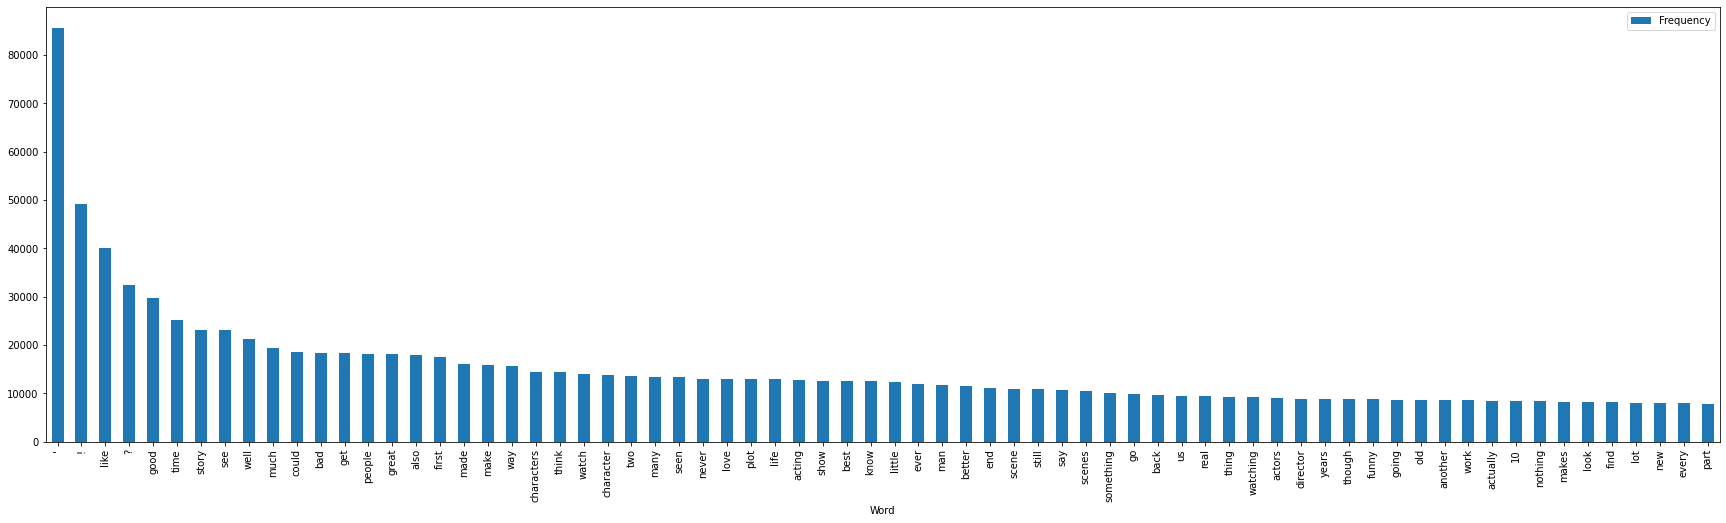

In [54]:
top_N = 70

words = (movies.review.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

In [60]:
rslt.transpose()

Word,'s,!,like,?,time,good,make,charact,see,get,watch,stori,well,scene,look,show,bad,',much,end,go,great,could,peopl,love,also,first,think,act,play,way,thing,made,know,say,seem,work,come,plot,actor,two,want,mani,seen,year,take,never,life,best,tri,littl,ever,man,better,give,still,find,perform,part,feel,use,someth,director,actual,back,interest,lot,real,us,guy
Frequency,63266,49164,45191,32336,31946,30175,30012,28768,28229,27960,27868,25268,21769,21429,19936,19909,19806,19440,19313,19088,18716,18699,18586,18372,18317,17972,17739,17543,17479,17365,17227,16508,16149,15176,14987,14857,13885,13873,13793,13592,13541,13498,13482,13370,13254,13149,12979,12926,12625,12521,12425,12027,11966,11453,11436,10932,10775,10726,10534,10350,10227,10213,10035,10007,9946,9758,9719,9430,9383,9252


In [65]:
def remove_apostrophe_s(review_text):
    review_text = re.sub(r"\'s", "", review_text)
    # review_text = re.sub(r"\s{2,}", " ", review_text)
    return review_text

movies['review'] = movies['review'].apply(remove_apostrophe_s)
sample_reviews()

44323    thing surpri number peopl like direct clint ea...
13439    singl greatest ever seen davey mr slaussen sim...
1741     oh misfir bad mind wonder drift away onto thin...
33606    controversi german journalist jutta rabe got d...
4579     gurinda chada  semi autobiograph 2002 gentl po...
18690    well peopl might go see watch trashi rubber pv...
23925    lauren himmel  debut well direct nice polish f...
Name: review, dtype: object

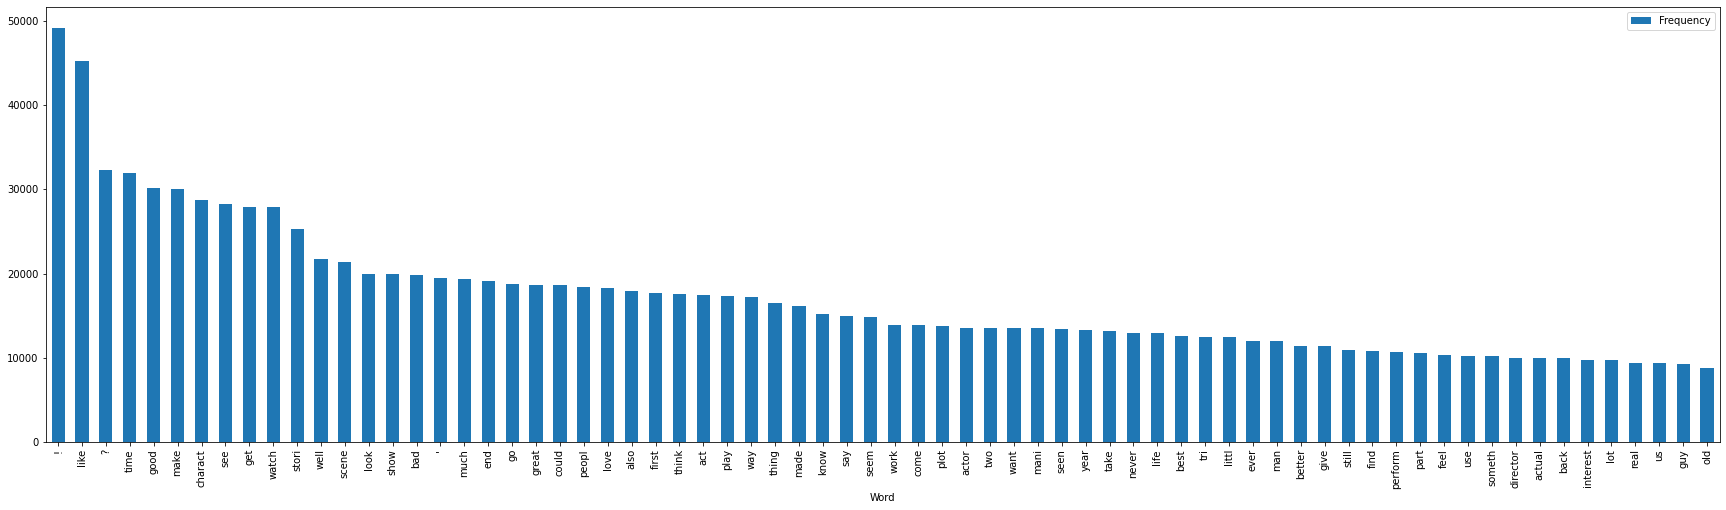

Word           !   like      ?   time   good  ...   lot  real    us   guy   old
Frequency  49164  45191  32336  31946  30175  ...  9719  9430  9383  9252  8804

[1 rows x 70 columns]


In [67]:
top_N = 70

words = (movie.review.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

In [68]:
rslt.transpose()

Word,!,like,?,time,good,make,charact,see,get,watch,stori,well,scene,look,show,bad,',much,end,go,great,could,peopl,love,also,first,think,act,play,way,thing,made,know,say,seem,work,come,plot,actor,two,want,mani,seen,year,take,never,life,best,tri,littl,ever,man,better,give,still,find,perform,part,feel,use,someth,director,actual,back,interest,lot,real,us,guy,old
Frequency,49164,45191,32336,31946,30175,30012,28768,28229,27960,27868,25268,21769,21429,19936,19909,19806,19440,19313,19088,18716,18699,18586,18372,18317,17972,17739,17543,17479,17365,17227,16508,16149,15176,14987,14857,13885,13873,13793,13592,13541,13498,13482,13370,13254,13149,12979,12926,12625,12521,12425,12027,11966,11453,11436,10932,10775,10726,10534,10350,10227,10213,10035,10007,9946,9758,9719,9430,9383,9252,8804


## Visualize the positive and negative reviews as wordclouds


In [0]:
pos_string = ""
pos = movies.loc[movies.sentiment == 1, 'review']
for review in pos:
    pos_string += review
    pos_string += " "

neg_string = ""
neg = movies.loc[movies.sentiment == 0, 'review']
for review in neg:
    neg_string += review
    neg_string += " "

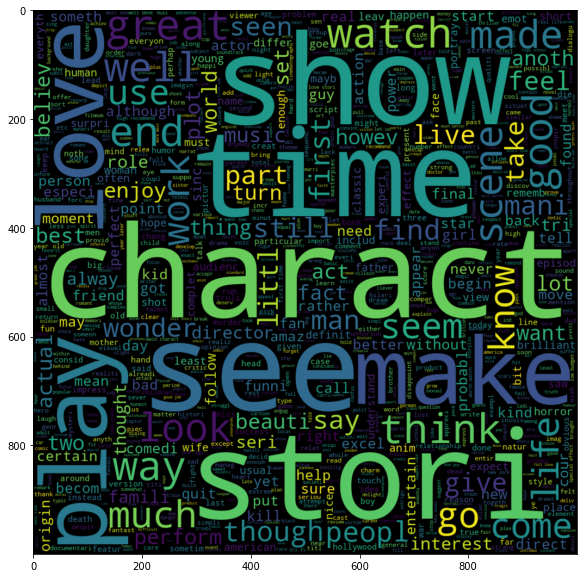

In [92]:
plt.figure(figsize=(10,10))
WC=WordCloud(width=1200, height=1200, max_words=1400, min_font_size=4)
positive_words=WC.generate(pos_string)
plt.imshow(positive_words,interpolation='bilinear')
plt.axis("off")
plt.show()

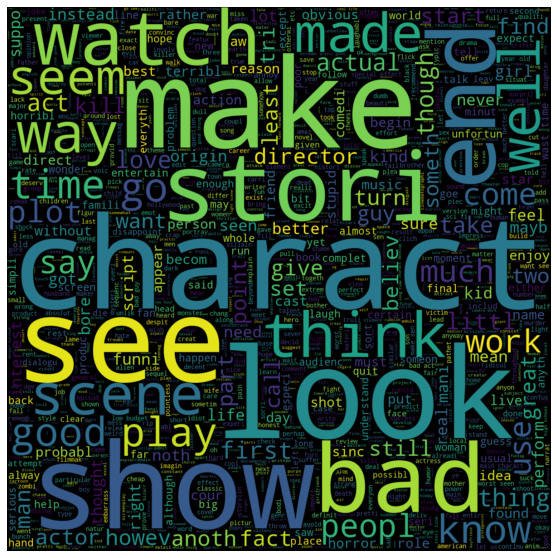

In [97]:
plt.figure(figsize=(10,10))
WC=WordCloud(width=1200, height=1200, max_words=1400, min_font_size=4)
negative_words=WC.generate(neg_string)
plt.imshow(negative_words,interpolation='bilinear')
plt.axis("off")
plt.show()

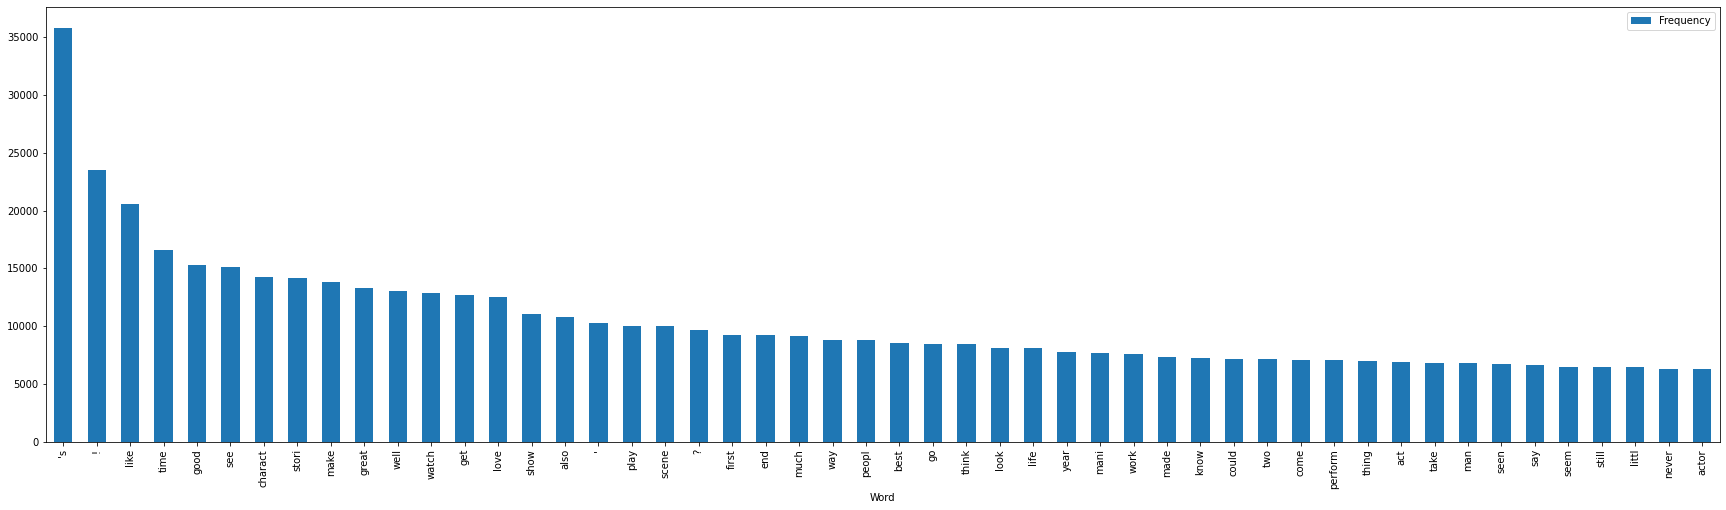

In [98]:
top_N = 50

words = (pos.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

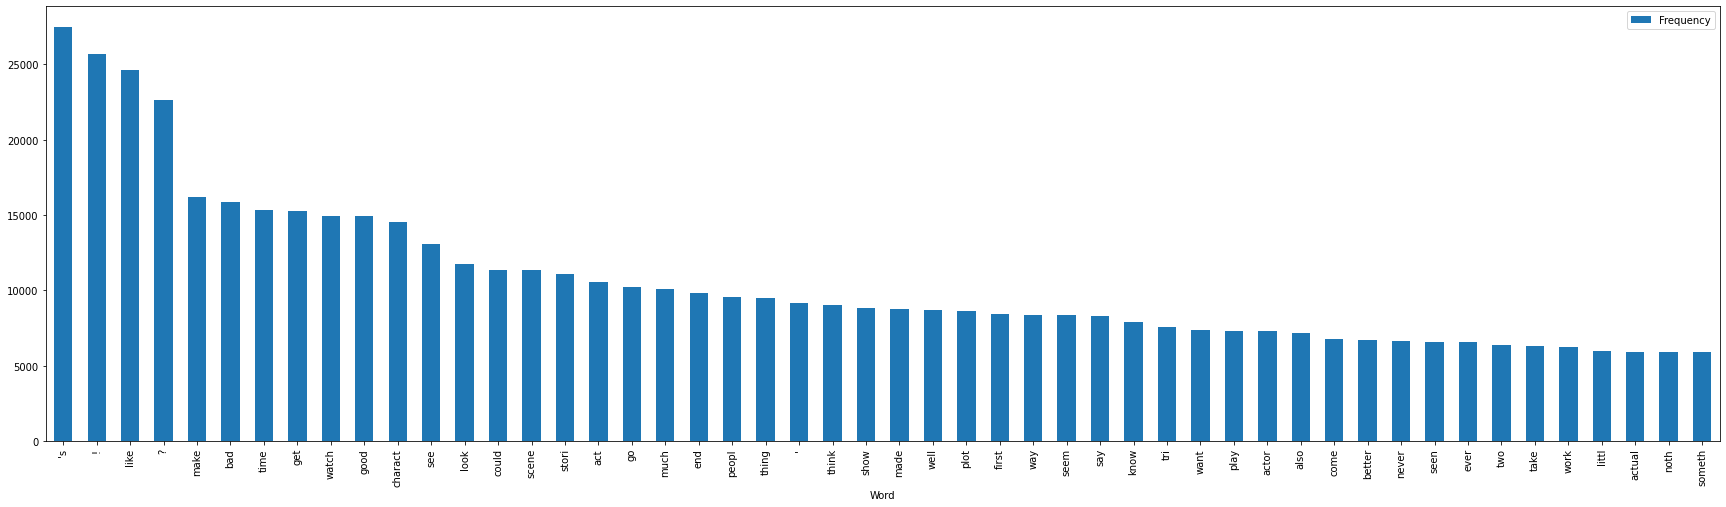

In [99]:
top_N = 50

words = (neg.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

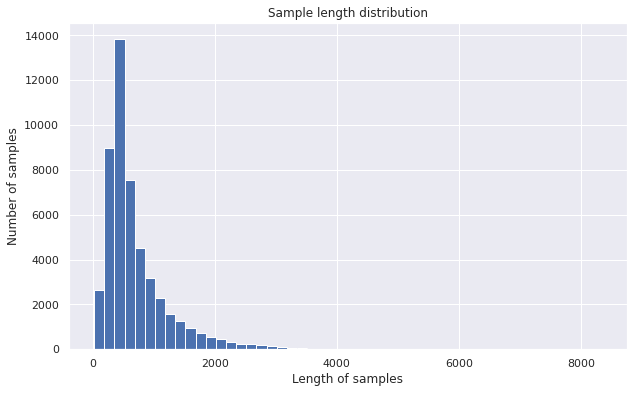

In [102]:
# Now, let's see the average number of words per sample
sns.set(rc={'figure.figsize' : (12, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})

plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(movies['review'])], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

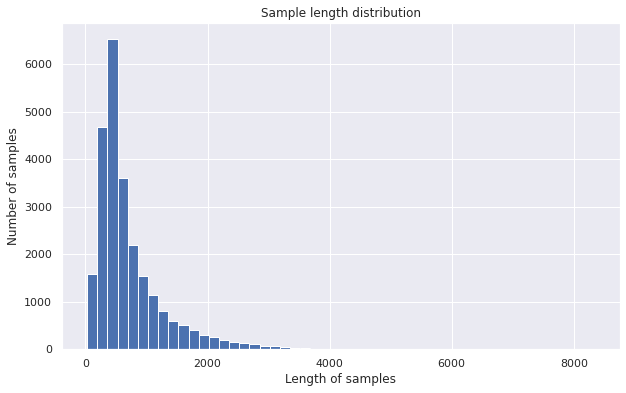

In [104]:
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(pos)], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

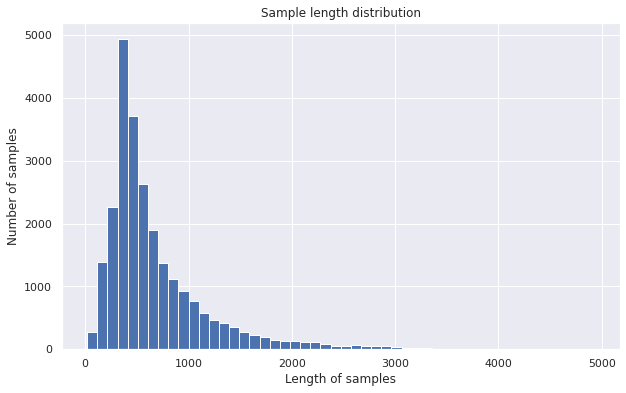

In [105]:
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(neg)], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [0]:
# add lenght as feature?